<a href="https://colab.research.google.com/github/charliesire/training_ciroquo_transposition/blob/main/notebook_toypb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pymcmcstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 2.2 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/charliesire/training_ciroquo_transposition.git # Get all useful files

Cloning into 'training_ciroquo_transposition'...
remote: Enumerating objects: 977, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (106/106), done.
remote: Total 977 (delta 57), reused 0 (delta 0), pack-reused 871 (from 1)
Receiving objects: 100% (977/977), 455.90 MiB | 16.27 MiB/s, done.
Resolving deltas: 100% (207/207), done.


# First, run all the different strategies

The functions studied here are defined in the file toy_pb.py:

$$f_1(x, \lambda) = (0.2+\lambda_1)*ln(1+x) + \sqrt{\lambda_2}$$
$$f_2(x, \lambda) = sin(\frac{1}{2}\times(1+\lambda_1))exp(-\frac{1}{1+x}) + \lambda_2^{0.15}$$

$\lambda_1$ is the parameter to calibrate and $\lambda_2$ is the numerical variable representing the model error.

And we define the true values $y_t(x) = f_t(x+0.4, (0.5,0.5))$, then introducing a model error

In [3]:
import numpy                as np
import pandas as pd
import seaborn              as sns
%cd training_ciroquo_transposition

from investigate_alphamap import func_alphamap,check_repeat
from bayes_alpha import *
from bayes_lambda import *
from full_bayes import *
from toy_pb import *
from utils_plot_errors import *


/content/training_ciroquo_transposition


In [4]:
if(os.path.isdir("toy_pb")==False): #create repository to save results
    os.mkdir("toy_pb")

In [5]:
sigma = [0.1,0.05] #Standard deviation of the observation noise for each output variable
bMINlambda = np.array([0,0]) #lower bounds for lambda
bMAXlambda = np.array([1,1]) #upper bounds for lambda
nb_exp = 5 #Number of observations
# The true values are y(x) = f(x+0.4, [0.5,0.5])
true_values = pd.DataFrame(np.concatenate([[func(xx+0.4, np.array([0.5,0.5]), kk,False) for xx in np.linspace(0,1,7)[1:-1]] for kk in range(1,3)], axis=1))
true_values.columns = ["Y1", "Y2"]
np.random.seed(45)
results_measures = true_values + np.random.normal(size = (nb_exp,2))*sigma

mm_list = None

calib_only = [1,2] #index of the calibration problems to consider. [1,2] means that the two configurations will be tested: observations of the first variable, and then of the second one.

nb_outputs = 2
loo = False #boolean indicating if we work with leave-one-out
std_code = False

## Hierarchical model

In [6]:
index_lambda_p = [0] #indexes of the four physical parameters
index_lambda_q = [1] #indexes of the two numerical parameters
model_error = True #Model error is  considered, so hierarchical bayesian model for the two numerical parameters
scale = 0.25 #std deviation of the truncated gaussian prior
pre_path = f"toy_pb/hierarchical_model" #where to store the results


### First we estimate alpha_map

In [7]:
M = 1000 #Initial number of i.i.d realizations
iter_lim = 100#Maximum number of iterations
threshold = 0.005

alpha_min = -4 #lower bound for alpha
alpha_max = 4 #upper bound for alpha
delta_alpha = 1 #maximum half width of the interval investigated. The interval will be [max(alpha_min, alpha_star - delta_alpha), min(alpha_max, alpha_star + delta_alpha)]

[func_alphamap(index_calib = index_calib, M = M, iter_lim = iter_lim, threshold = threshold, alpha_min = alpha_min, alpha_max = alpha_max, delta_alpha = delta_alpha, scale = scale, results_measures = results_measures.iloc[:,index_calib-1].values, sigma = sigma[index_calib-1], myCODE = myCODE, mm_list = mm_list, index_lambda_p = index_lambda_p, index_lambda_q = index_lambda_q, bMINlambda= bMINlambda, bMAXlambda = bMAXlambda, pre_path = pre_path, loo = loo, std_code = std_code) for index_calib in calib_only]

[None, None]

### Then we generate posterior samples $(A_i)_{i=1}^N \propto p(yobs \mid \alpha)p_A(\alpha)$

In [8]:
tune_size = 100
size = 200
rngseed = 10
num_chain = 3
M = 1000

samples_alpha = [MCMC_alpha_multichains(index_calib=index_calib, scale=scale, num_chain = num_chain, tune_size=tune_size, size=size, M = M,  alpha_min = alpha_min, alpha_max = alpha_max, delta_alpha = delta_alpha, rngseed=rngseed,  results_measures = results_measures.iloc[:,index_calib-1].values, sigma = sigma[index_calib-1], myCODE = myCODE, mm_list = mm_list, index_lambda_p=index_lambda_p, index_lambda_q=index_lambda_q, bMINlambda=bMINlambda, bMAXlambda=bMAXlambda, pre_path = pre_path, loo = loo, std_code = std_code) for index_calib in calib_only]

 [-----------------100%-----------------] 300 of 300 complete in 2.8 sec

### Then we generate posterior samples $(\Lambda_k)_{k=1}^M \propto p(yobs \mid \lambda)p_\Lambda(\lambda\mid \alpha_{MAP})$

In [9]:
tune_size = 200
size = 500
num_chain = 3
rngseed=1234
#MCMC_multichains generates the posterior samples
[MCMC_lambda_multichains(index_calib = index_calib, model_error = model_error, scale = scale, num_chain = num_chain, tune_size = tune_size, size = size, myCODE = myCODE, mm_list = mm_list,  results_measures = results_measures.iloc[:,index_calib-1].values, sigma = sigma[index_calib-1], index_lambda_p = index_lambda_p, index_lambda_q = index_lambda_q, bMINlambda = bMINlambda, bMAXlambda = bMAXlambda, rngseed = rngseed, pre_path = pre_path, nb_outputs = nb_outputs, loo = loo, std_code = std_code) for index_calib in calib_only]

#bayes_lambda_results computes the performance metrics associated with this sample (with plug-in alpha)
[bayes_lambda_results(index_calib = index_calib, pre_path = pre_path, true_values = true_values, std_code = std_code) for index_calib in calib_only]

 [-----------------100%-----------------] 700 of 700 complete in 0.7 sec

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


[None, None]

Finally, we compute the estimator o
$$E_{N,M}(h(\Lambda)) = \frac{1}{N}\sum_{i=1}^N \frac{\sum_{k=1}^M h(\Lambda_k) \frac{p_{\boldsymbol{\Lambda}}(\boldsymbol{\Lambda}_k \mid \boldsymbol{\boldsymbol{A_i}})}{p_{\boldsymbol{\Lambda}}(\boldsymbol{\Lambda}_k \mid \boldsymbol{\boldsymbol{\alpha}^\star})}}{\sum_{k=1}^M  \frac{p_{\boldsymbol{\Lambda}}(\boldsymbol{\Lambda}_k \mid \boldsymbol{\boldsymbol{A_i}})}{p_{\boldsymbol{\Lambda}}(\boldsymbol{\Lambda}_k \mid \boldsymbol{\boldsymbol{\alpha}^\star})}}$$

In [10]:
[full_bayes_results(index_calib = index_calib, index_lambda_p = index_lambda_p, index_lambda_q = index_lambda_q, scale = scale, bMINlambda = bMINlambda, bMAXlambda = bMAXlambda,pre_path = pre_path, true_values = true_values,loo = loo, std_code = std_code) for index_calib in calib_only]

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


[None, None]

## Uniform prior

In [11]:
index_lambda_p = [0,1] #here, all variables are considered with uniform prior
index_lambda_q = [] #no hierarchical model
model_error = True
scale = None
pre_path = f"toy_pb/uniform_error" #where to store the results

### We generate posterior samples $(\Lambda_k)_{k=1}^M \propto p(yobs \mid \lambda)p_\Lambda(\lambda)$

In [12]:
tune_size = 200
size = 500
num_chain = 3
rngseed=1234
#MCMC_multichains generates the posterior samples
[MCMC_lambda_multichains(index_calib = index_calib, model_error = model_error, scale = scale, num_chain = num_chain, tune_size = tune_size, size = size, myCODE = myCODE, mm_list = mm_list,  results_measures = results_measures.iloc[:,index_calib-1].values, sigma = sigma[index_calib-1], index_lambda_p = index_lambda_p, index_lambda_q = index_lambda_q, bMINlambda = bMINlambda, bMAXlambda = bMAXlambda, rngseed = rngseed, pre_path = pre_path, nb_outputs = nb_outputs, loo = loo, std_code = std_code) for index_calib in calib_only]

#bayes_lambda_results computes the performance metrics associated with this sample (with plug-in alpha)
[bayes_lambda_results(index_calib = index_calib, pre_path = pre_path, true_values = true_values, std_code = std_code) for index_calib in calib_only]

 [-----------------100%-----------------] 700 of 700 complete in 0.6 sec

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


[None, None]

## No model error

In [13]:
index_lambda_p = [0] #indexes of the four physical parameters
index_lambda_q = [1] #indexes of the two numerical parameters
model_error = False #No model error is considered, so the two numerical parameters are fixed
scale = None
pre_path = f"toy_pb/no_error"

### We generate posterior samples $(\Lambda_k)_{k=1}^M \propto p(yobs \mid \lambda)p_\Lambda(\lambda)$

In [14]:
tune_size = 200
size = 500
num_chain = 3
rngseed=1234

#MCMC_multichains generates the posterior samples
[MCMC_lambda_multichains(index_calib = index_calib, model_error = model_error, scale = scale, num_chain = num_chain, tune_size = tune_size, size = size, myCODE = myCODE, mm_list = mm_list,  results_measures = results_measures.iloc[:,index_calib-1].values, sigma = sigma[index_calib-1], index_lambda_p = index_lambda_p, index_lambda_q = index_lambda_q, bMINlambda = bMINlambda, bMAXlambda = bMAXlambda, rngseed = rngseed, pre_path = pre_path, nb_outputs = nb_outputs, loo = loo, std_code = std_code) for index_calib in calib_only]

#bayes_lambda_results computes the performance metrics associated with this sample (with plug-in alpha)
[bayes_lambda_results(index_calib = index_calib, pre_path = pre_path, true_values = true_values, std_code = std_code) for index_calib in calib_only]

 [-----------------100%-----------------] 700 of 700 complete in 0.5 sec

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


[None, None]

# Then, plot the results

In [15]:
pre_path = f"toy_pb/"
variable_names = [r"$y_1$", r"$y_2$"] #names of the three outputs

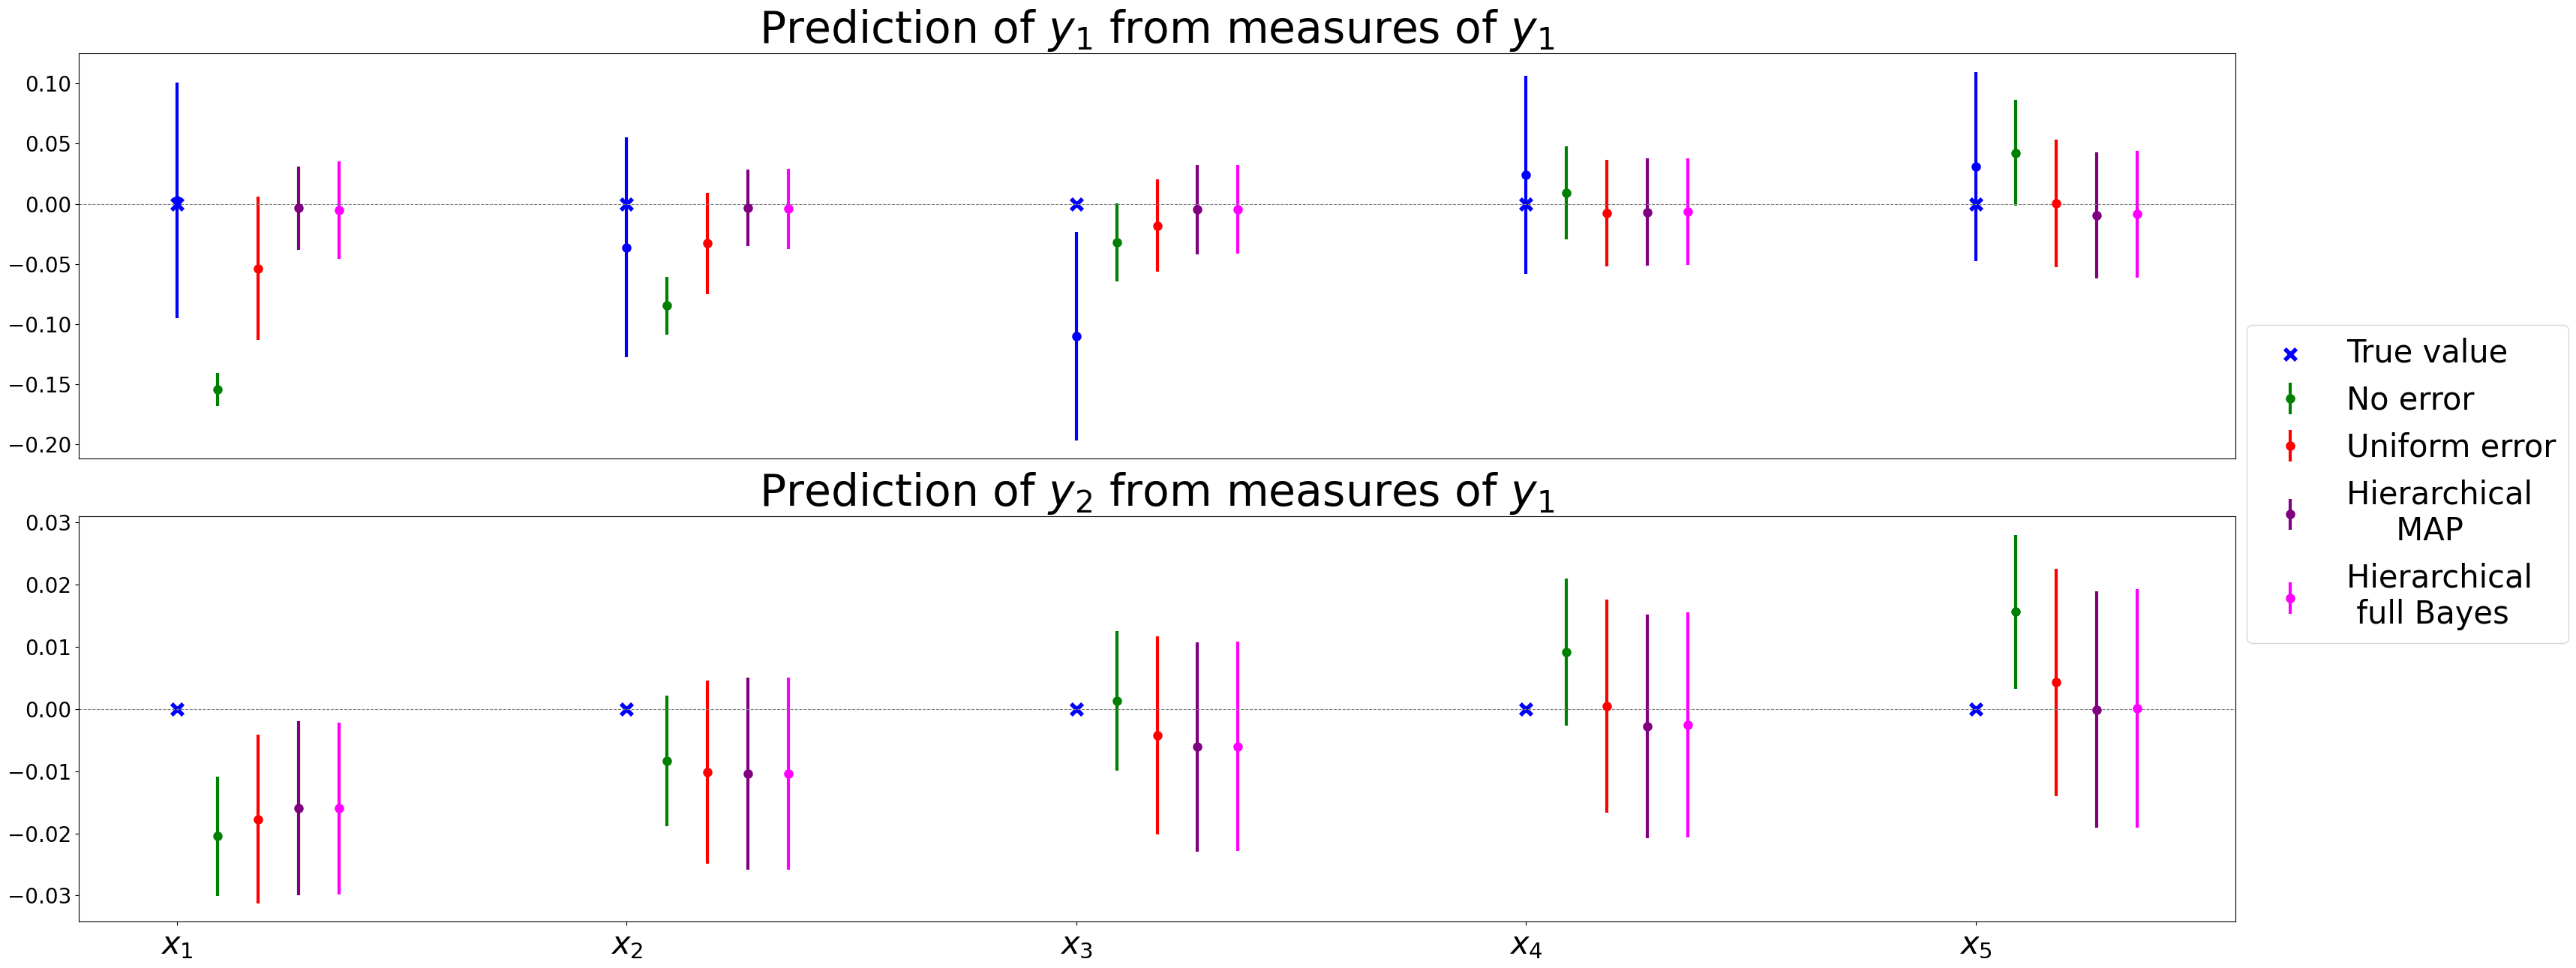

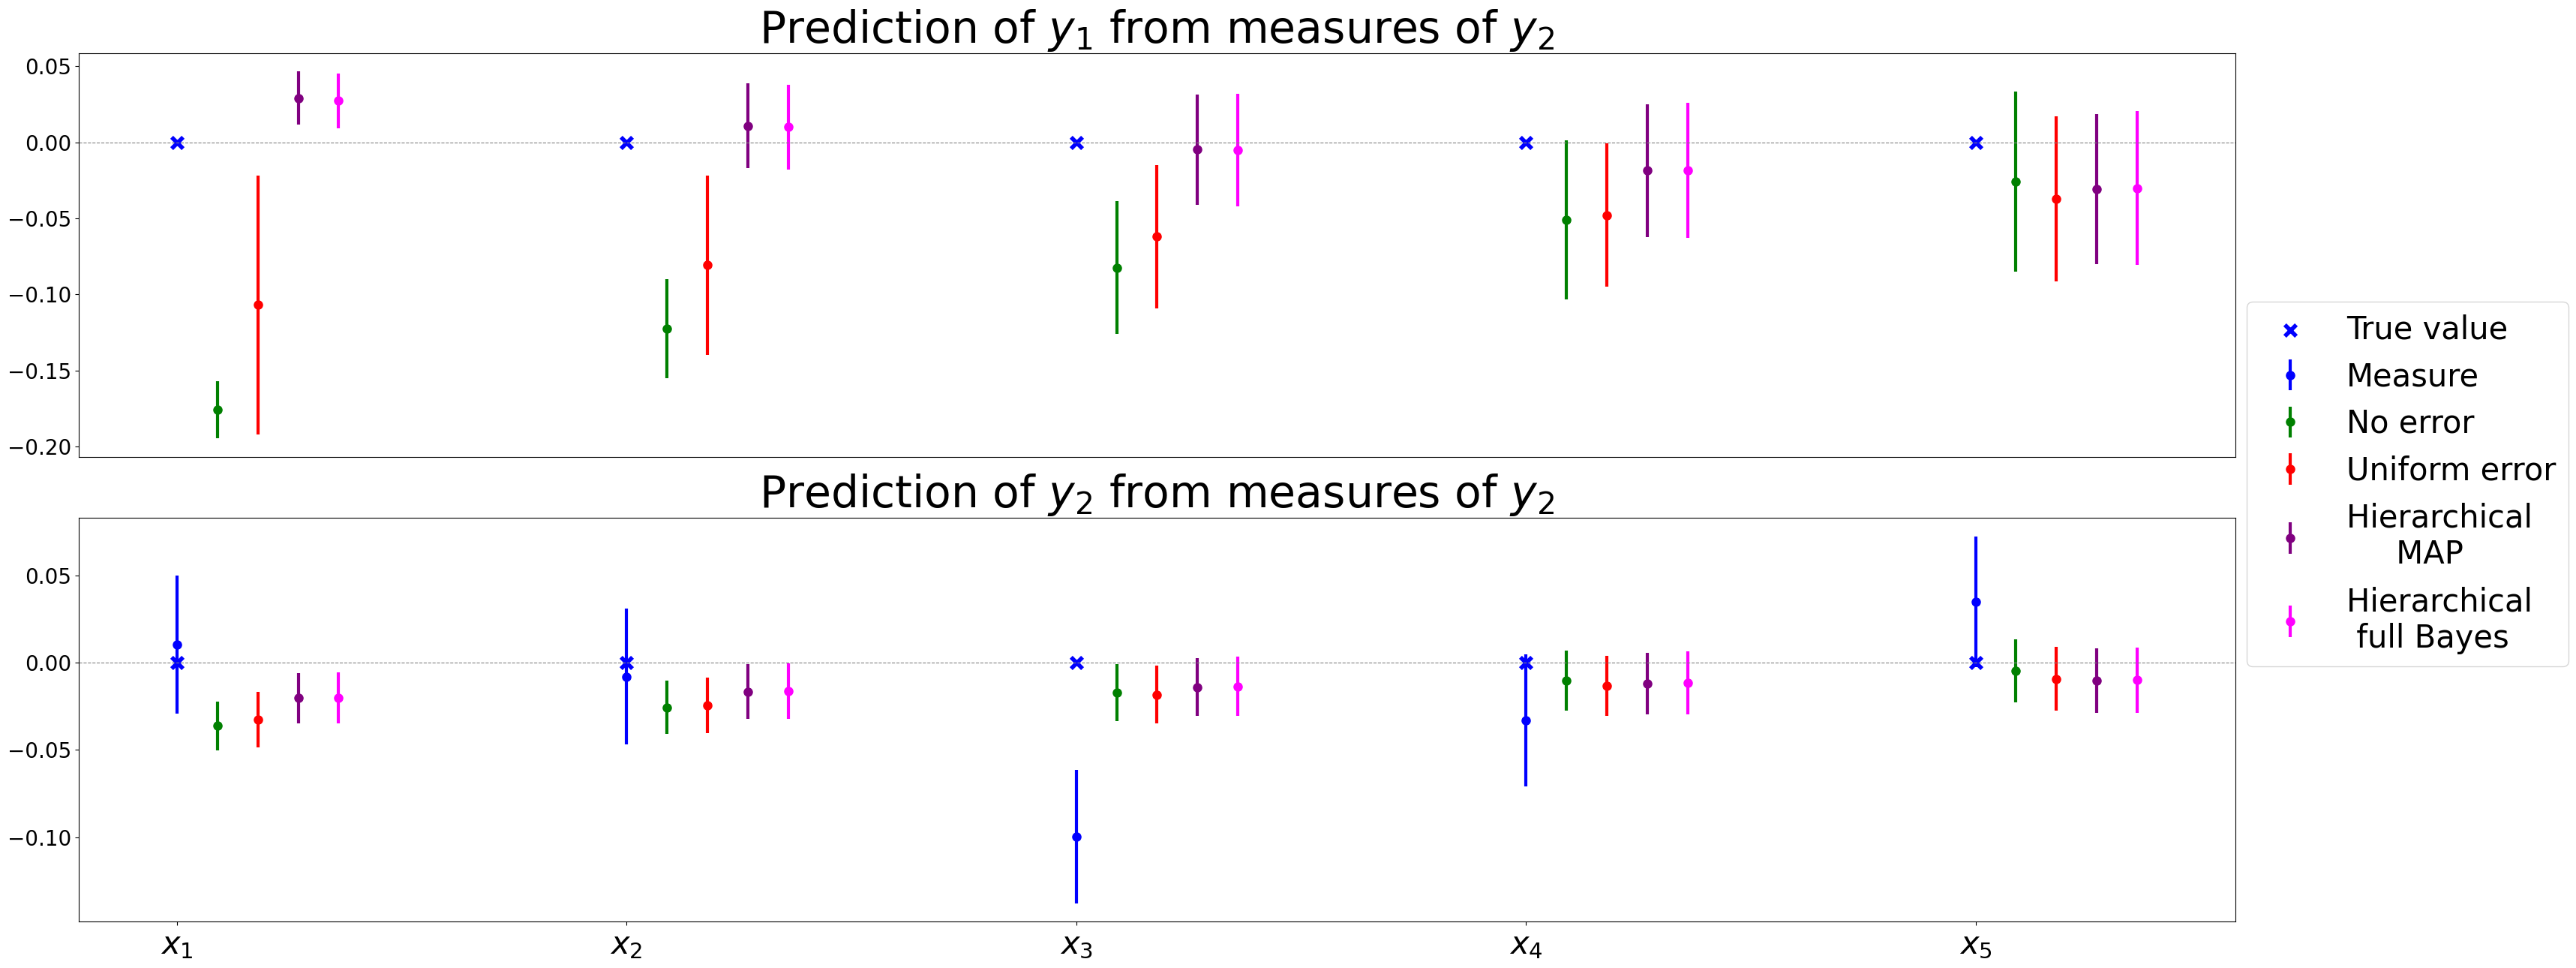

In [16]:
plot_mean_std(index_calib = 1, results_measures = results_measures, true_values = true_values, sigma = sigma, pre_path = pre_path, variable_names = variable_names, no_error = True, unif_error = True, hierarchical_map = True, full_bayes = True, savefig = True)
plot_mean_std(index_calib = 2, results_measures = results_measures, true_values = true_values, sigma = sigma, pre_path = pre_path, variable_names = variable_names, no_error = True, unif_error = True, hierarchical_map = True, full_bayes = True, savefig = True)


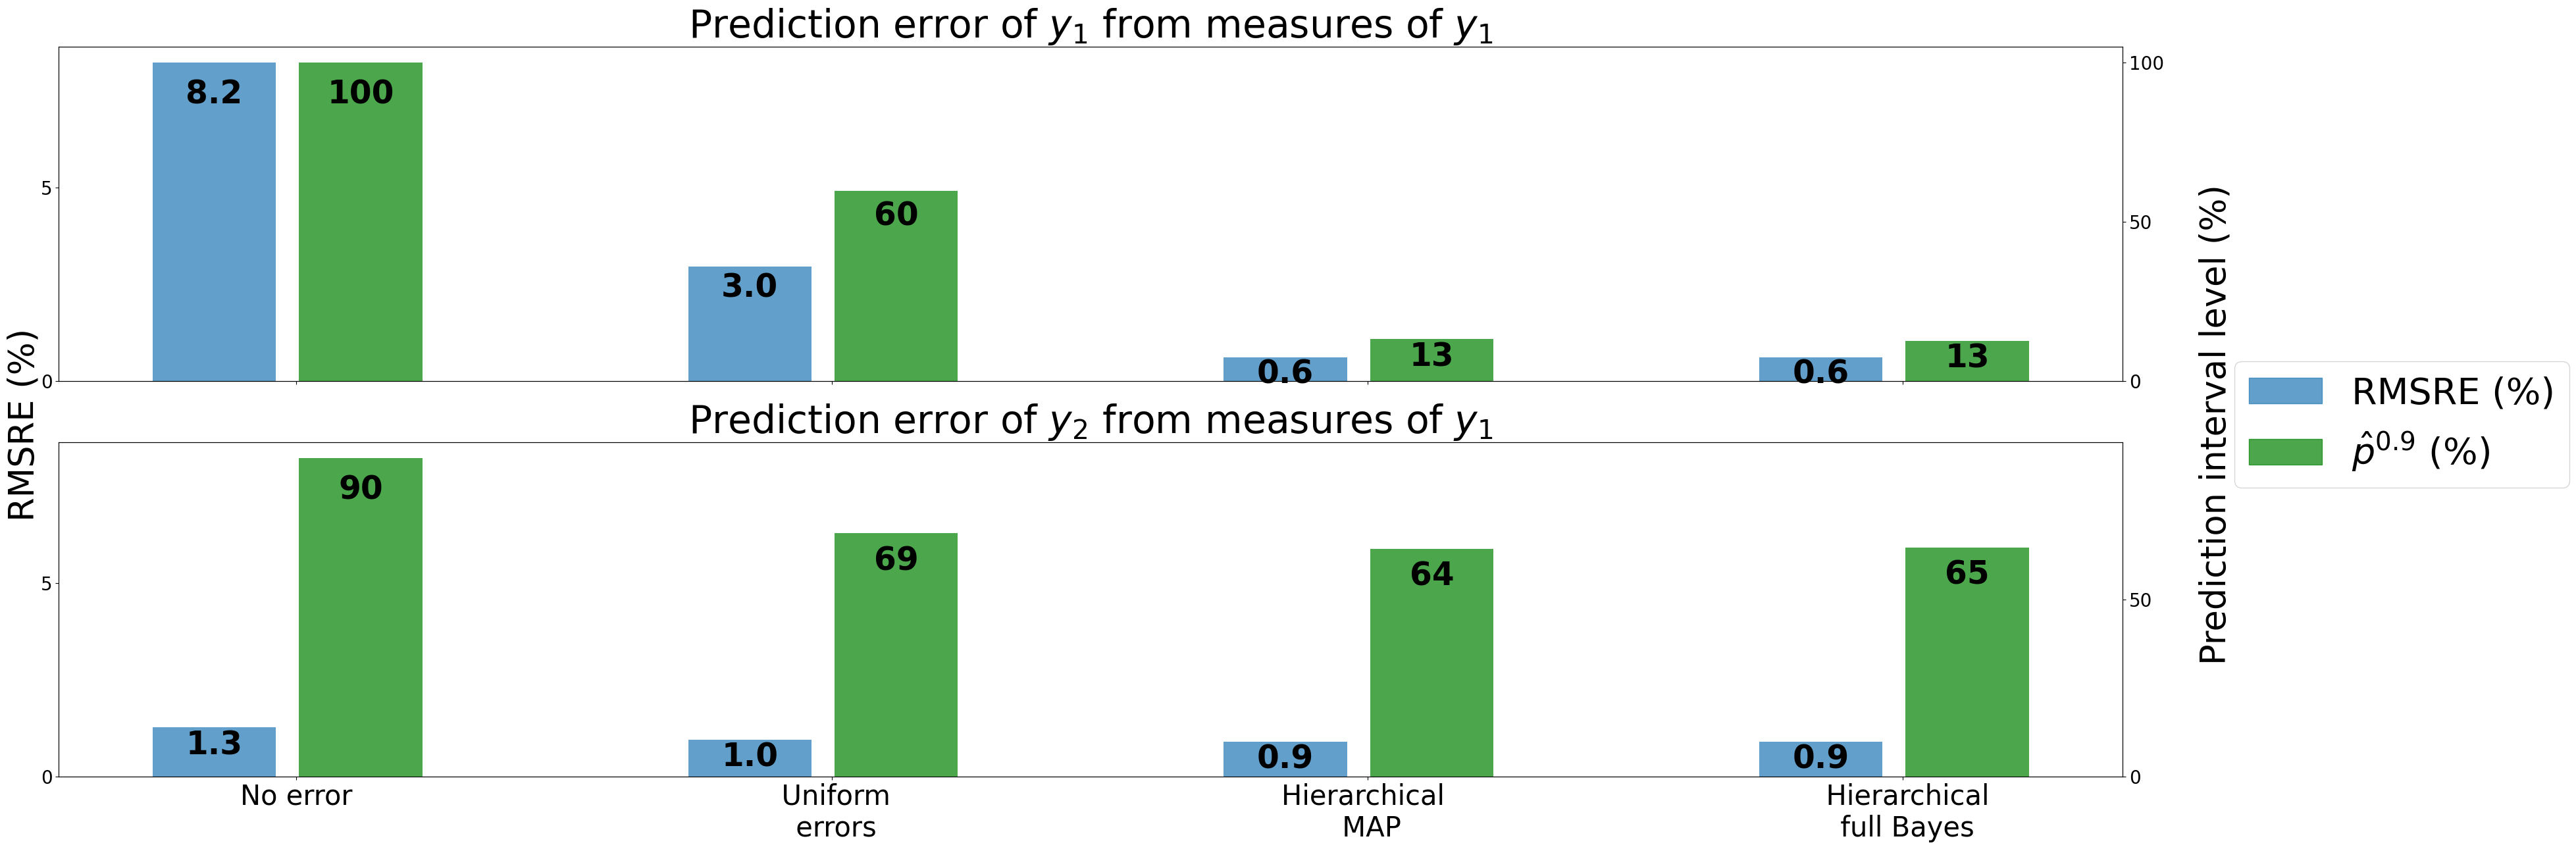

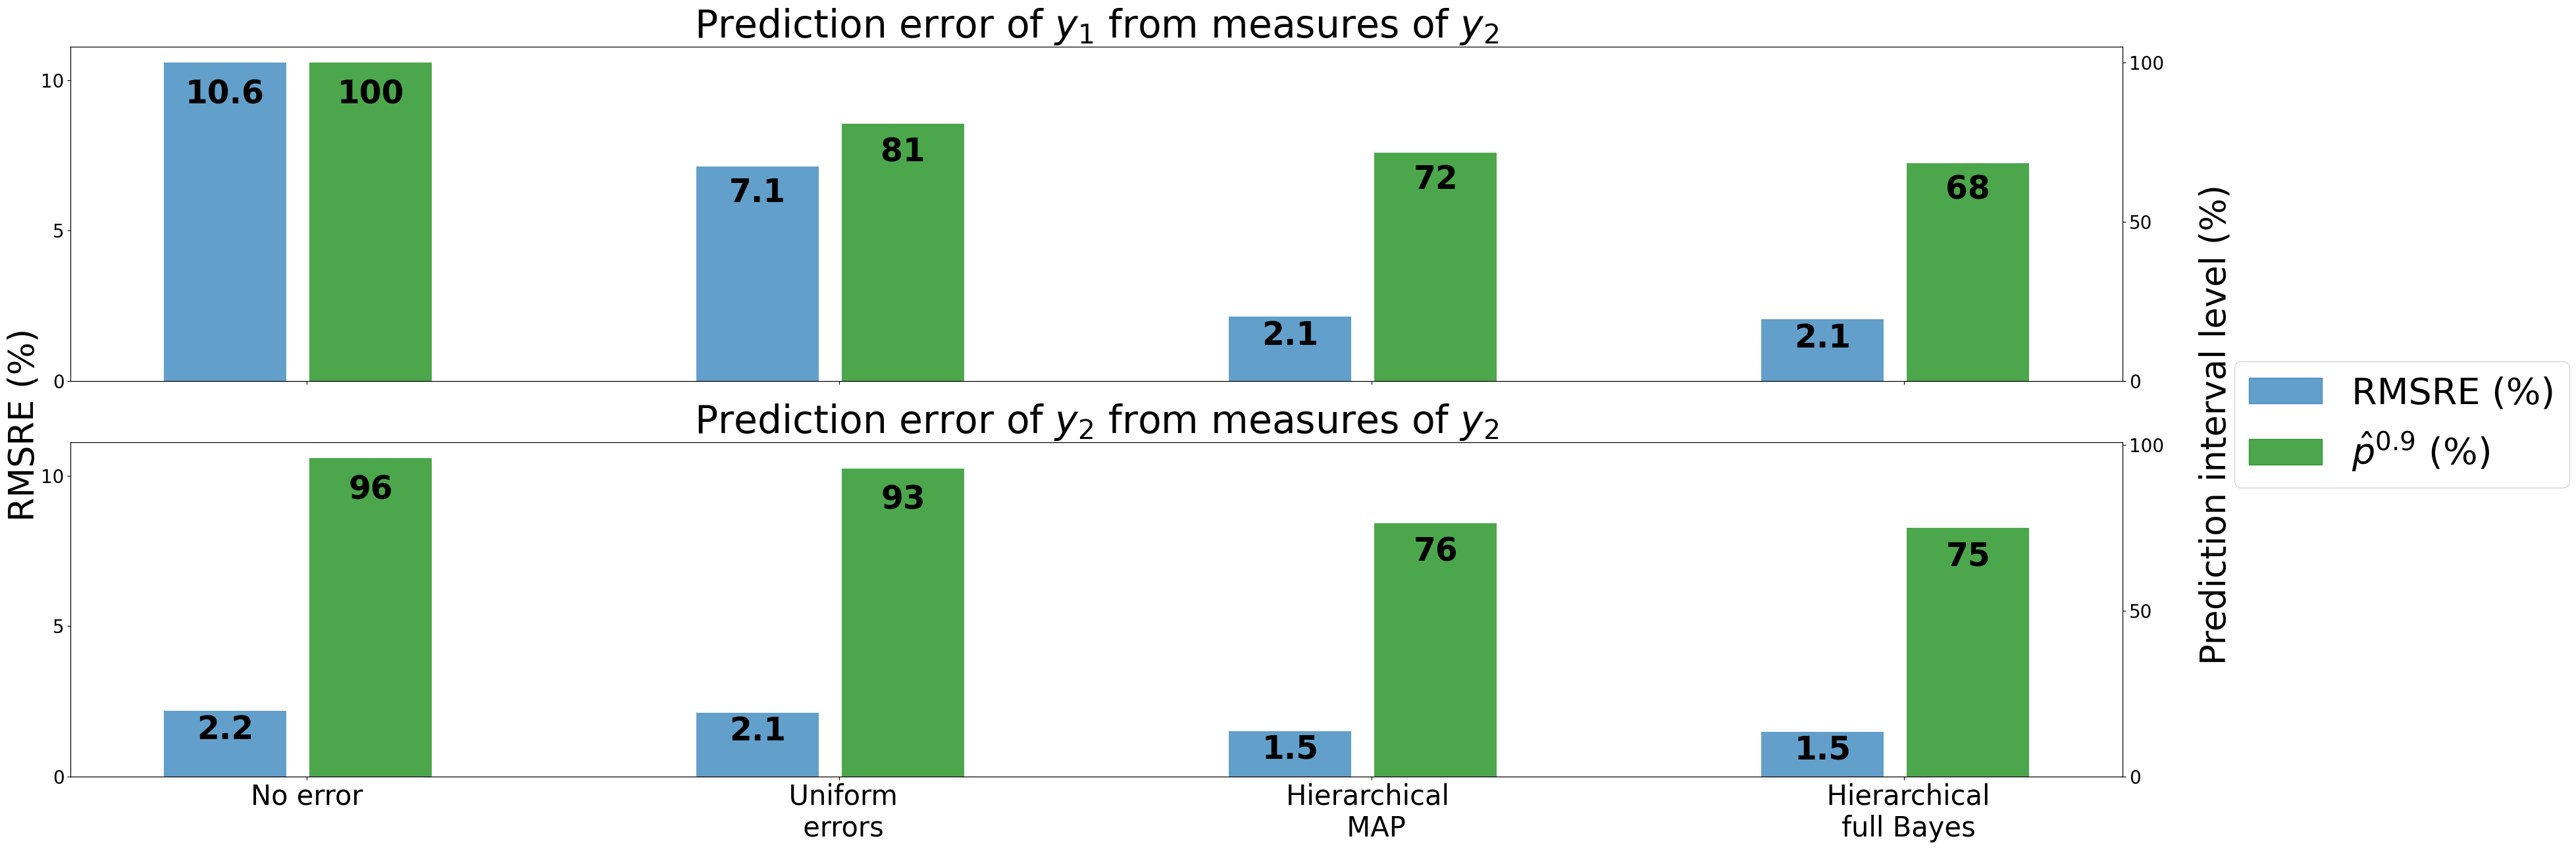

In [17]:
plot_errors(index_calib = 1, pre_path = pre_path, variable_names = variable_names, no_error = True, unif_error = True, hierarchical_map = True, full_bayes = True, savefig = True, nb_outputs = nb_outputs)
plot_errors(index_calib = 2, pre_path = pre_path, variable_names = variable_names, no_error = True, unif_error = True, hierarchical_map = True, full_bayes = True, savefig = True, nb_outputs = nb_outputs)

IndexError: index 3 is out of bounds for axis 0 with size 3

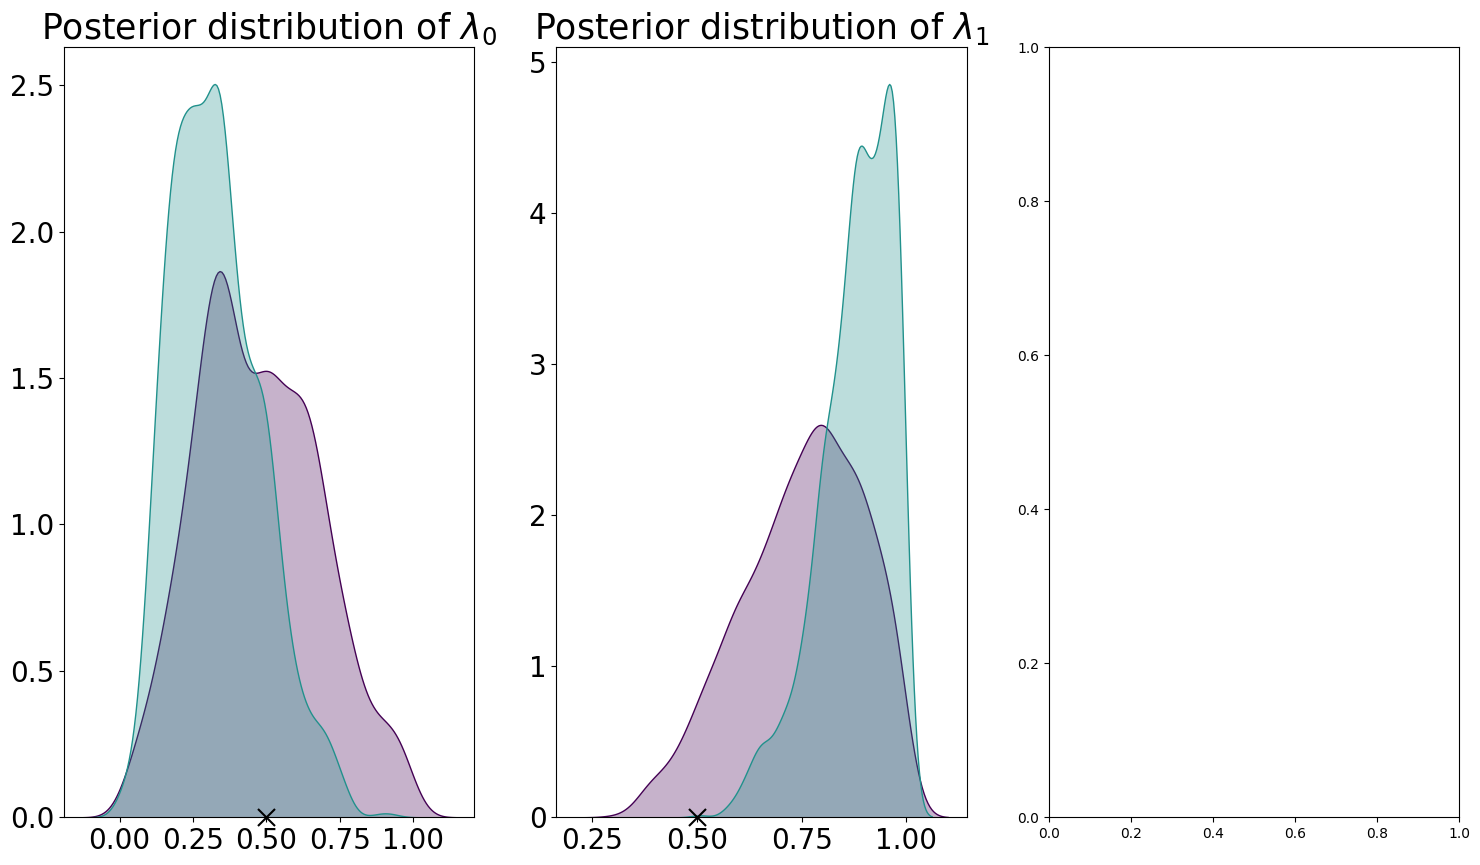

In [19]:
params = [r"$\lambda_0$", r"$\lambda_1$"]

lambda_0 = (np.array([0.5,0.5])-bMINlambda)/(bMAXlambda-bMINlambda) #lambda0 used for the measures

index_calib=1 #which calibration variable

sample_unif = pd.read_csv(pre_path + f"uniform_error/calib_{index_calib}/lambd_post.csv", index_col = 0).values #uniform error sample
sample_hier = pd.read_csv(pre_path + f"hierarchical_model/calib_{index_calib}/lambd_post.csv", index_col = 0).values #hierarchical model sample
sample_unif = np.apply_along_axis(lambda x:(x-bMINlambda)/(bMAXlambda-bMINlambda), 1, sample_unif) #normalized sample
sample_hier = np.apply_along_axis(lambda x:(x-bMINlambda)/(bMAXlambda-bMINlambda), 1, sample_hier) #normalized sample
plot_samples(list_samples = [sample_unif, sample_hier], list_labels = ['Uniform \n  error','Hierarchical \n     MAP'], params = params, lambda_0 = lambda_0)

In [ ]:
M = 10000
beta = 1.05
size_grid = 100
rngseed = 1
idx_loo = None
scale = 0.25
[plot_confidence_alpha(index_calib = index_calib, scale = scale, M = M, beta = beta, size_grid = size_grid, alpha_min =alpha_min, alpha_max = alpha_max, delta_alpha = delta_alpha, rngseed = rngseed, results_measures = results_measures.iloc[:,index_calib-1].values, sigma = sigma[index_calib-1], myCODE = myCODE, mm_list = mm_list, index_lambda_p = index_lambda_p, index_lambda_q = index_lambda_q, bMINlambda = bMINlambda, bMAXlambda = bMAXlambda, pre_path = pre_path, idx_loo = idx_loo, std_code = std_code) for index_calib in calib_only]